

```
This assignment involves working with a 200-sample synthetic data to perform binary classification using a KNN approach.

Submit using mycourses dropbox. Save the file in ipynb format. Your submission will be shared with all your classmates.

You are allowed to research code online or use LLM code generators.

Requirements:

1. Load the data (code provided) and show the shape of the numpy ndarray.
2. Plot the data as a 2-D space comprised of the features, with the samples
   colored by the associated class (3rd column in the numpy array).
3. Implement a nearest-neighbor model to predict the label based on majority
   voting of the k nearest sample's labels. Set k to {1,3,5,15,200}.
   Present the accuracy of the predictions for each k.
   Your implementation of distance calculation should not use loops. Do not use sklearn.neighbors.KNeighborsClassifier.
4. Present the confusion matrices for each k.
5. Plot the decision boundary of the KNN classifier model for k=1.
6. Plot the data now with the two prediction regions separated by the decision
   boundary as blue (for predicting as '0') and orange (otherwise), for k=1.
7. Repeat the plot with the colored regions and the decision boundary for k=3.
8. Repeat the plot with the colored regions and the decision boundary for k=5.
9. Repeat the plot with the colored regions and the decision boundary for k=7.
10. Repeat the plot with the colored regions and the decision boundary for k=200.
```



## 1. Load data & imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# !wget https://github.com/eduardocoelholima/635-code-multiterm/raw/refs/heads/main/data/binary_classification.

data = np.load('../data/binary_classification_knn.npy')

df = pd.DataFrame(data) 

## 2. Plot data w/ associated classes

(-2.4998534020399017, 3.3558049669193197)

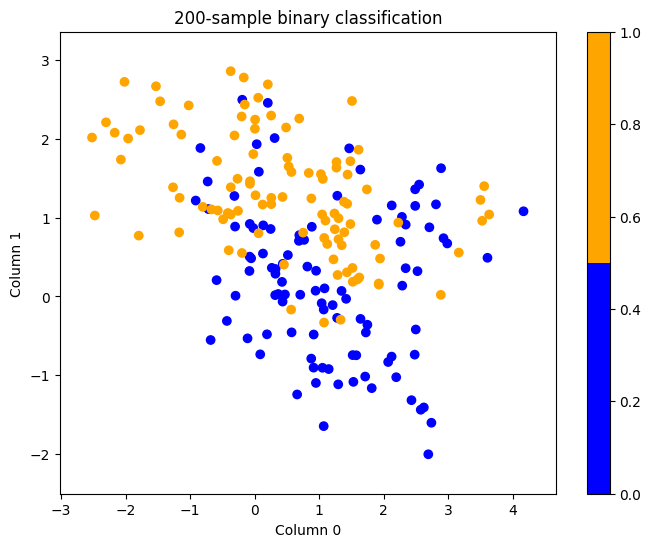

In [2]:
from IPython.display import display
from matplotlib.colors import ListedColormap

colors = ["blue", "orange"]
cmap = ListedColormap(
    colors=colors
)

MARGIN = 0.5

# create plots
fig, ax = plt.subplots(figsize=(8, 6))

# create scatter plots in different colors
scatter = ax.scatter(
    x=df[0],
    y=df[1],
    c=df[2],
    cmap=cmap
)

cbar = fig.colorbar(scatter, ax=ax)

ax.set_xlabel("Column 0")
ax.set_ylabel("Column 1")
ax.set_title(f"{len(df)}-sample binary classification")

ax.set_xlim(df[0].min() - MARGIN , df[0].max() + MARGIN)
ax.set_ylim(df[1].min() - MARGIN , df[1].max() + MARGIN)

## 3. KNN to predict label based on majority
## 4. Confusion Matrices for each k
k $\in$ {1,3,5,15,200}. We will calculate the euclidean distance values for every point of data using numpy broadcasting, though we will need to loop through the dataset to perform this calculation on each point. `np.argsort()` and `np.argmax()` are functions that we will use to extract the corresponding indices in `labels` since we don't want to include the classification in the distance calculation. We will then, using a majority vote, check to see if the predicted and actual class matches, and find the ratio of correct predictions to total samples for accuracy.

I wasn't really sure on step 4 so I used Gemini with the prompt "Is there a good way to create a confusion matrix in numpy or scikit-learn?", and I figured I would just write this code manually since there's no easy answer. I also got it to generate a Matplotlib matrix plot for the confusion matrix with this prompt: "Given four values, how can I make a 2 by 2 confusion matrix plot with matplotlib?" I edited the code to suit my needs (moving the x-axis to the top, for example).


Resulting accuracies for each k value:

Accuracy for k = 1: 1.00
Confusion matrix for k = 1:


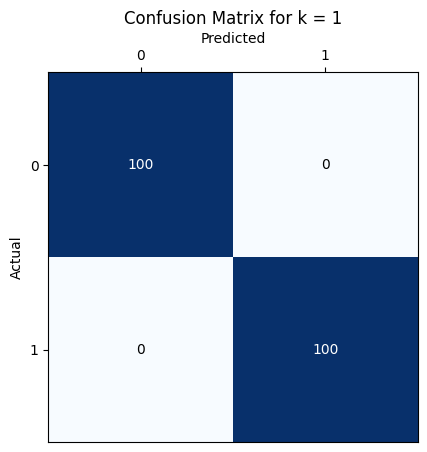

Accuracy for k = 3: 0.87
Confusion matrix for k = 3:


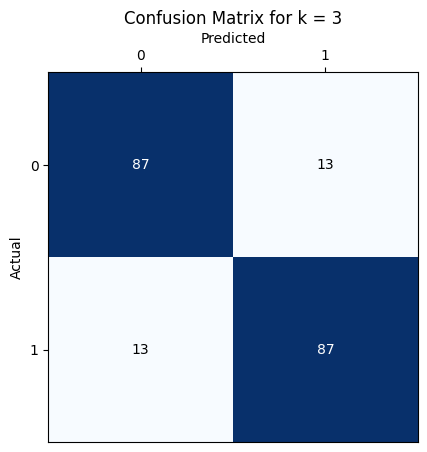

Accuracy for k = 5: 0.87
Confusion matrix for k = 5:


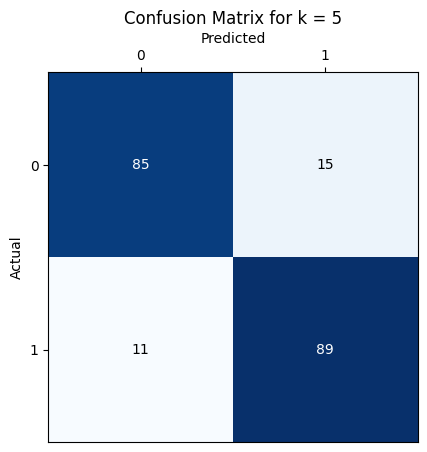

Accuracy for k = 15: 0.84
Confusion matrix for k = 15:


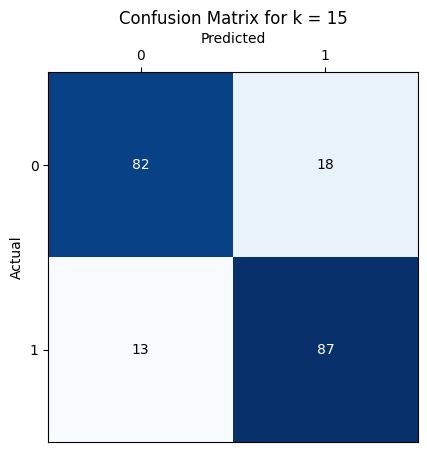

Accuracy for k = 200: 0.50
Confusion matrix for k = 200:


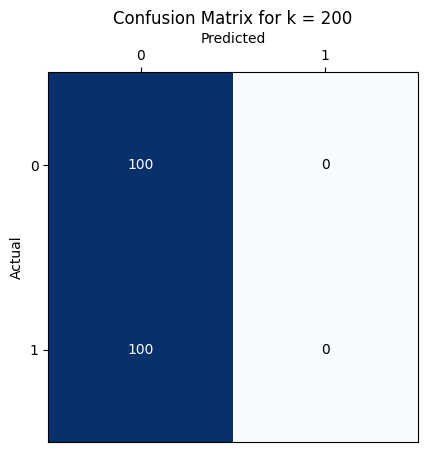

In [3]:
def plot_matrix(tp, tn, fp, fn, k):
    #  actual columns, predicted rows
    #  0 1
    # 0
    # 1
    matrix = np.array(
        [[tn, fp],
        [fn, tp]]
    )

    data_labels = ["0", "1"]

    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for k = {k}")
    
    # move x-axis to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    # create tick marks
    tick_marks = np.arange(len(data_labels))
    
    plt.xticks(tick_marks, data_labels)
    plt.yticks(tick_marks, data_labels)
    
    fmt = 'd'
    thresh = matrix.max() / 2.

    # ensures the text is readable
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, format(matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if matrix[i, j] > thresh else "black")

    # label
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

k_vals = [1, 3, 5, 15, 200]
labels = data[:, 2:]
total = len(data)

print("Resulting accuracies for each k value:\n")

for k in k_vals:
    tp, tn, fp, fn = 0, 0, 0, 0

    # use numpy broadcasting - this loop is not for calculating distance but for accuracy
    for row in data:
        # calculate euclidean distance
        difference = data - row
        difference = difference[:, :2]

        # get distances
        squared_diff = difference ** 2
        squared_diff_sum = np.sum(squared_diff, axis=1)
        distances = np.sqrt(squared_diff_sum)
        
        # sort distances
        k_indices = np.argsort(distances)[:k]
        k_neighbors = labels[k_indices]

        # get most frequent label
        unique, counts = np.unique(k_neighbors, return_counts=True)
        decision = unique[np.argmax(counts)]

        # get confusion matrix values
        correct_label = row[2]
        if (correct_label == 0 and decision == 0):
            tn += 1
        elif (correct_label == 1 and decision == 1):
            tp += 1
        elif (correct_label == 1 and decision == 0):
            fn += 1
        elif (correct_label == 0 and decision == 1):
            fp += 1


    print(f"Accuracy for k = {k}: {(tp + tn) / total:.2f}")
    print(f"Confusion matrix for k = {k}:")

    # plot matrix
    plot_matrix(tp, tn, fp, fn, k)

## 5-10. Plot decision boundaries for k=1, 3, 5, 7, and 200
For plotting decision boundaries, we can use a meshgrid. I ended up rewriting the KNN algorithm as a function that can take in a series of grid points from the mesh grid and make predictions based off of that. I recreate the plot each time so things don't draw on top of each other and display every graph.

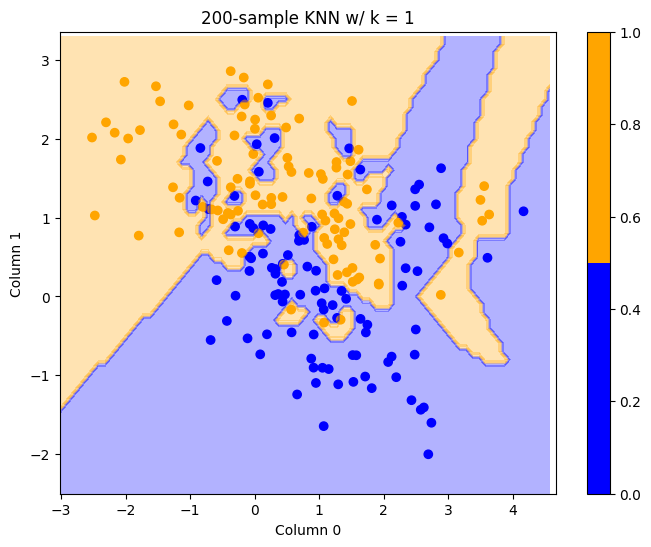

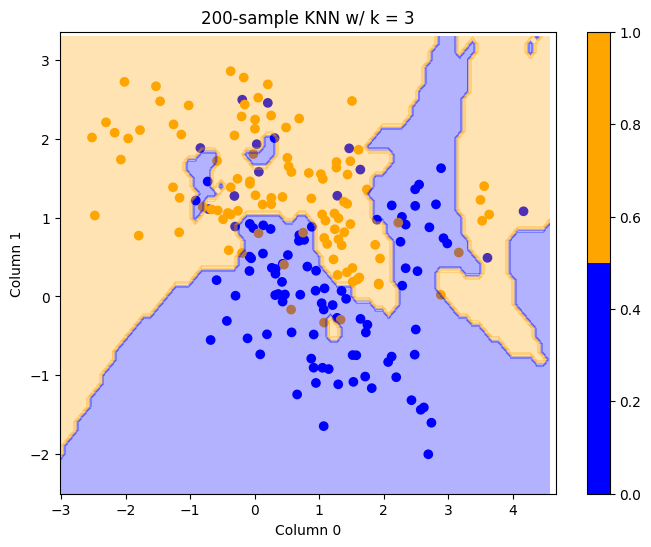

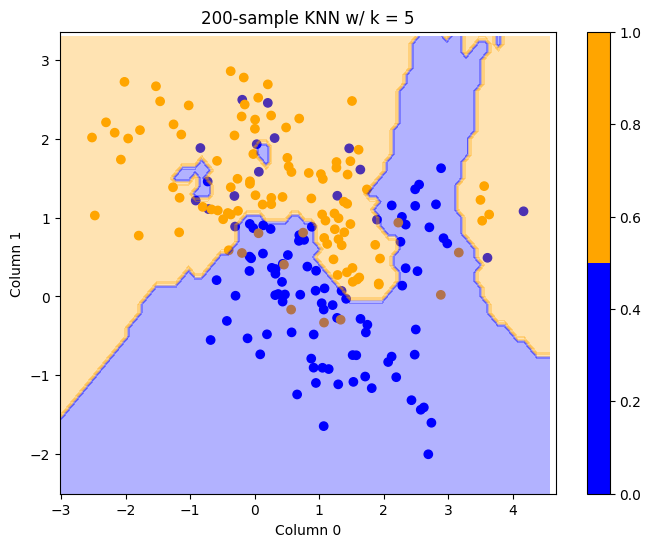

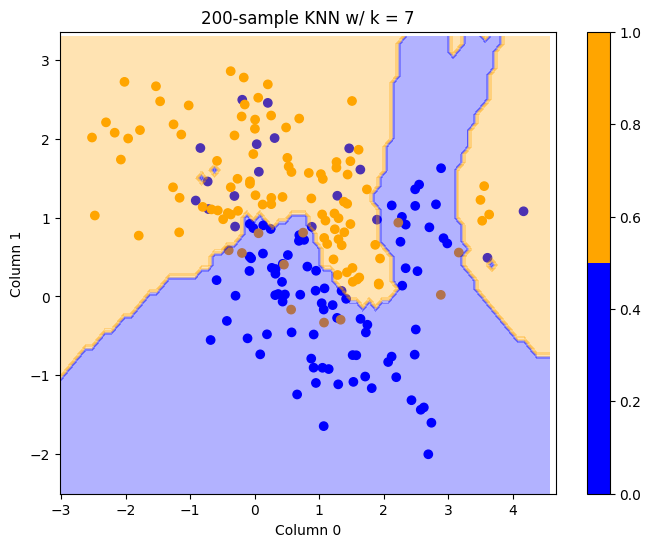

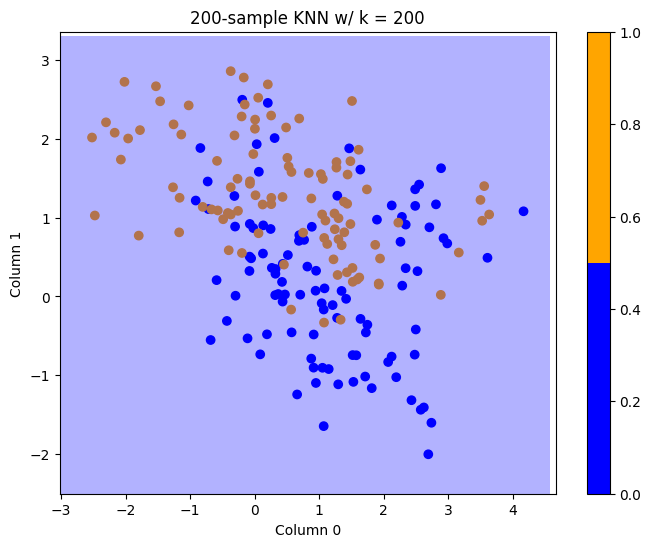

In [4]:
def predict_bulk(points, k):
    decisions = []

    for point in points:
        # calculate euclidean distance
        difference = data[:, :2] - point

        # get distances
        squared_diff = difference ** 2
        squared_diff_sum = np.sum(squared_diff, axis=1)
        distances = np.sqrt(squared_diff_sum)
        
        # sort distances
        k_indices = np.argsort(distances)[:k]
        k_neighbors = labels[k_indices]

        # get most frequent label
        unique, counts = np.unique(k_neighbors, return_counts=True)
        decisions.append(unique[np.argmax(counts)])

    return np.array(decisions)

# create mesh grid
MARGIN = 0.5
STEP = 0.1
x_min, x_max = data[:, 0].min() - MARGIN, data[:, 0].max() + MARGIN
y_min, y_max = data[:, 1].min() - MARGIN, data[:, 1].max() + MARGIN
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, STEP),
    np.arange(y_min, y_max, STEP),
)

# flatten for bulk prediction
flattened_points = np.vstack((xx.ravel(), yy.ravel())).T

k_vals = [1, 3, 5, 7, 200]
# run for all k values
for k in k_vals:
    # create plots
    fig, ax = plt.subplots(figsize=(8, 6))

    # create scatter plots in different colors
    scatter = ax.scatter(
        x=df[0],
        y=df[1],
        c=df[2],
        cmap=cmap
    )

    cbar = fig.colorbar(scatter, ax=ax)

    ax.set_xlabel("Column 0")
    ax.set_ylabel("Column 1")
    ax.set_title(f"{len(df)}-sample KNN w/ k = {k}")

    ax.set_xlim(df[0].min() - MARGIN , df[0].max() + MARGIN)
    ax.set_ylim(df[1].min() - MARGIN , df[1].max() + MARGIN)

    # perform prediction + reshape back
    bulk_prediction = predict_bulk(flattened_points, k=k).reshape(xx.shape)

    # plot decision boundary
    ax.contourf(xx, yy, bulk_prediction, alpha=0.3, cmap=cmap)